### Introduction
Consider to solve 1D wave equation in the domain of $(0 \leq x \leq L)\times(0 \leq t \leq T)$ with finite difference:
$$c^2\frac{\partial {^2 u(x,t)}}{\partial{x^2}} = \frac{\partial {^2 u(x,t)}}{\partial{t^2}}$$

where $c$ is the wave velocity. <br/>
Boundary conditions:
$$u(x=0, t) = 0, u(x=L, t) = 0$$
Initial conditions at $t=0$:
$$u(x, t=0) = g(x), \frac{\partial{u(x, t=0)}}{\partial{t}} = 0$$
Observed point at $x=x_r$

### Method of Lines
Unlike finite difference, we start with descretizing ONLY the space with step of $\Delta x$. Then the second-order derivative w.r.t $x$ is expressed as:
$$\frac{\partial ^2 u(x_m,t)}{\partial x^2} \approx \frac{u_{m-1}(t) - 2u_m (t) + u_{m+1} (t)}{\Delta x^2}$$

where $m=0,1,2,...,M$. Therefore:

$$\frac{d^2 u_m(t)}{d t^2} = \frac{c^2}{\Delta x^2}[u_{m-1}(t) - 2u_m (t) + u_{m+1} (t)]$$

with which, we reduce a PDE to a system of ODEs, and then many well developed algorithms can be utilzied [1].

[[1] MOL(method of liens)](https://hplgit.github.io/prog4comp/doc/pub/p4c-sphinx-Python/._pylight006.html) <br>

For speeding up computation, we want to express the above equations in Matrix formula:
$$\frac{d^2 \mathbf{u}(t)}{d t^2} = \mathbf{Ku}(t), \frac{d \mathbf{u}(0)}{d t} = \mathbf{0}, \mathbf{u}(0)=\mathbf{g}$$

where $\mathbf{u}(t)=[u_0(t), u_1(t), u_2(t), \cdots, u_M(t)]^T$, $\mathbf{g}=[g(0),g(\Delta x),g(2\Delta x),\cdots,g((M-1)\Delta x),g(M\Delta x)]^T$, and

$$ \mathbf{K} =  \frac{1}{\Delta x^2} \begin{bmatrix}
0   &  &  &  & &\\
c^2 & -2c^2 & c^2 &  & &\\
& c^2   & -2c^2 & c^2 &  &\\
& & \ddots & \ddots & \ddots & \\
& & & c^2 & -2c^2 & c^2 \\
& & &  &  & 0
\end{bmatrix}
$$

To reduce the order of derivation, let $\mathbf{v}(t)=d \mathbf{u}(t)/d t$, then:
$$\frac{\mathbf{v}(t)}{dt}=\mathbf{Ku}(t), \mathbf{v}(t)=0$$
Let $\mathbf{w}(t) = [\mathbf{u}(t), \mathbf{v}(t)]^T$, reformulate all equations and initial conditions as
$$\frac{d \mathbf{w}(t)}{d t} = \mathbf{Hw}(t), \mathbf{w}(0) = [\mathbf{g}^T, \mathbf{0}^T]^T$$
where
$$\mathbf{H} = \begin{bmatrix}
\mathbf{0} & \mathbf{I}\\
\mathbf{K} & \mathbf{0}
\end{bmatrix}
$$

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [5]:
L = 500 # um
dx = 1 # um
Nx = int(L/dx)
xgrid = np.arange(0, Nx+1)*dx
c = 1000 # m/s
r = c/dx

# construct K matrix
v = r**2*np.ones_like(xgrid)
v[0], v[-1] = 0, 0
K = np.diag(-2*v) + np.diag(v[1:],k=-1) + np.diag(v[:-1],k=1)
print("K = \n",K) # check whether K is right

K = 
 [[       0.        0.        0. ...        0.        0.        0.]
 [ 1000000. -2000000.  1000000. ...        0.        0.        0.]
 [       0.  1000000. -2000000. ...        0.        0.        0.]
 ...
 [       0.        0.        0. ... -2000000.  1000000.        0.]
 [       0.        0.        0. ...  1000000. -2000000.  1000000.]
 [       0.        0.        0. ...        0.        0.        0.]]


In [14]:
I = np.eye(Nx+1)
N = np.zeros([Nx+1]*2)
H = np.block([[N, I],[K, N]])
print("H = \n", H)

H = 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


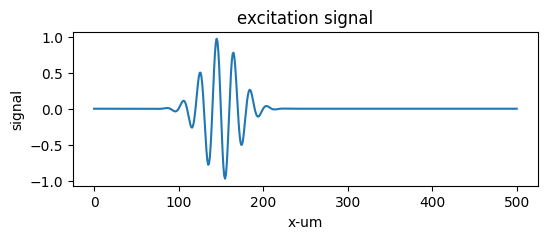

In [15]:
# plot excitation signal
xf = 150 # um
mf = int(xf/dx)
xr = 150 # ums
mr = int(xr/dx)

freq = 50 # MHz
def f(x):
    return np.exp(-(x-xf)**2/(0.2*xf)**2)*np.sin(2*np.pi*freq*x/c)

exc_sig = f(xgrid)
fig = plt.figure(figsize=[6,2])
plt.plot(xgrid, exc_sig)
plt.xlabel('x-um')
plt.ylabel('signal')
plt.title('excitation signal')
plt.show()

In [22]:
# solve wave 1d
def get_dydt(y,t): 
    dydt = np.matmul(H, y)
    return dydt 

u_ini = exc_sig # column vector
u_ini[0], u_ini[-1] = 0, 0
v_ini = np.zeros((Nx+1,))

w_ini = np.concatenate([u_ini, v_ini])

T = 2 # us
dt = 0.5*dx/c # us
Nt = int(T/dt)
tgrid = np.arange(0, Nt+1)*dt

sol = odeint(get_dydt, w_ini, tgrid)

In [26]:
U = sol[:, :Nx+1].T
ur = U[mr, :]

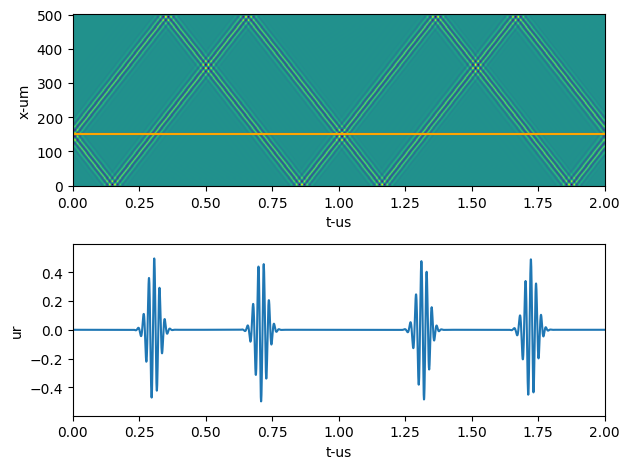

In [27]:
# visualize results
fig, ax = plt.subplots(2)
xx,tt = np.meshgrid(xgrid, tgrid, indexing='ij')
ax[0].pcolor(tt,xx,U)
ax[0].axhline(y=xf, color='r', linestyle='-')
ax[0].axhline(y=xr, color='orange', linestyle='-')
ax[0].set_xlabel('t-us')
ax[0].set_ylabel('x-um')

ax[1].plot(tgrid, ur)
ax[1].set_xlabel('t-us')
ax[1].set_ylabel('ur')
ax[1].margins(x=0.0, y=0.1)
fig.tight_layout()

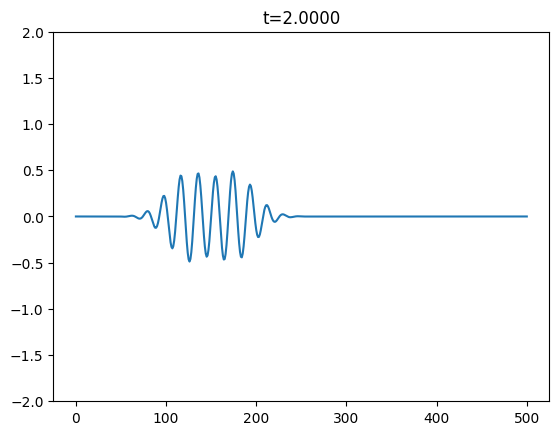

In [29]:
# wave propagation in spacextime
import time
from IPython import display

for i in range(0,Nt+1, 50):
    try:
        display.clear_output(wait=True)
        plt.plot(xgrid, U[:, i])
        plt.ylim((-2, 2))
        plt.title(f't={tgrid[i]:.4f}')
        plt.show()
    except KeyboardInterrupt:
        break